In [2]:
'''
script no 1 ..

this is the script for the data preprocessing part of the whole project
~ ssmj

#grindingHard


This script deals :
1) immporting the dependencies
2) then we create the dataset i.e we mount google drive and from the raw folder data which contains subfolders cataract, galucoma, etc and merge them into one csv file contaianig images encocded into base64 format
3) Next overwrite the files by resizing each img into 224*224 format
4) Visualise the data ... frm the visualisation we see a right skewed pixel distribution so considering CLAHE algorithm here ..bfore applying CLAHE check all images to RGB just in case
5) Apply clahe here
6) the class imbalance is minimal so wont affect the outcome much
7) over write csv data in the dataset file in drive
'''

'\nscript no 1 ..\n\nthis is the script for the data preprocessing part of the whole project\n~ ssmj\n\n#grindingHard\n\n\nThis script deals :\n1) immporting the dependencies\n2) then we create the dataset i.e we mount google drive and from the raw folder data which contains subfolders cataract, galucoma, etc and merge them into one csv file contaianig images encocded into base64 format\n3) Next overwrite the files by resizing each img into 224*224 format\n4) Visualise the data ... frm the visualisation we see a right skewed pixel distribution so considering CLAHE algorithm here ..bfore applying CLAHE check all images to RGB just in case\n5) Apply clahe here\n6) the class imbalance is minimal so wont affect the outcome much\n7) over write csv data in the dataset file in drive\n'

In [3]:
# dependenices
!pip install opencv-python-headless
import cv2
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
import base64
import io
from PIL import Image
from collections import Counter
#splitting
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
print("SUCCESS")

SUCCESS


**CREATING DATASET**

In [4]:
# mounting google colab and directories

drive.mount('/content/drive', force_remount=False)
dataset = '/content/drive/MyDrive/Colab Notebooks/personal/Eye disease/dataset'
cataract ='/content/drive/MyDrive/Colab Notebooks/personal/Eye disease/dataset/cataract'
glaucoma = '/content/drive/MyDrive/Colab Notebooks/personal/Eye disease/dataset/glaucoma'
normal = '/content/drive/MyDrive/Colab Notebooks/personal/Eye disease/dataset/normal'
dia_ret='/content/drive/MyDrive/Colab Notebooks/personal/Eye disease/dataset/diabetic_retinopathy'

# Mapping of folder paths to labels
folders = {
    'cataract': cataract,
    'glaucoma': glaucoma,
    'normal': normal,
    'diabetic_retinopathy': dia_ret
}

# Check the contents of the folders dictionary
print("Folders dictionary:")
print(folders)

# Verify if files exist in each folder
print("\nChecking file existence in each folder:")
for label, folder_path in folders.items():
    if os.path.exists(folder_path):
        files_in_folder = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        print(f"{label}: {len(files_in_folder)} image files found")
    else:
        print(f"{label}: Folder not found")

print("SUCCESS")

Mounted at /content/drive
Folders dictionary:
{'cataract': '/content/drive/MyDrive/Colab Notebooks/personal/Eye disease/dataset/cataract', 'glaucoma': '/content/drive/MyDrive/Colab Notebooks/personal/Eye disease/dataset/glaucoma', 'normal': '/content/drive/MyDrive/Colab Notebooks/personal/Eye disease/dataset/normal', 'diabetic_retinopathy': '/content/drive/MyDrive/Colab Notebooks/personal/Eye disease/dataset/diabetic_retinopathy'}

Checking file existence in each folder:
cataract: 1038 image files found
glaucoma: 1007 image files found
normal: 1074 image files found
diabetic_retinopathy: 1098 image files found
SUCCESS


In [5]:
# encode image as base64 string
def encode_image_to_base64(image_path):
    try:
        with open(image_path, "rb") as img_file:
            return base64.b64encode(img_file.read()).decode('utf-8')
    except Exception as e:
        print(f"Error encoding {image_path}: {e}")
        return None

data = []

for label, folder_path in folders.items():
    if not os.path.exists(folder_path):
        print(f"not found: {folder_path}")
        continue

    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            full_path = os.path.join(folder_path, filename)
            encoded = encode_image_to_base64(full_path)
            if encoded:
                data.append([encoded, label])


df = pd.DataFrame(data, columns=['image', 'label'])
df = df.sample(frac=1, random_state=42).reset_index(drop=True)


# Save to CSV
csv_path = os.path.join(dataset, 'data_encoded.csv')
df.to_csv(csv_path, index=False)

print(f"CSV saved at: {csv_path}")
df.head()

CSV saved at: /content/drive/MyDrive/Colab Notebooks/personal/Eye disease/dataset/data_encoded.csv


,image,label
0,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...,cataract
1,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAIBAQEBAQIBAQ...,normal
2,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAIBAQEBAQIBAQ...,normal
3,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...,glaucoma
4,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAIBAQEBAQIBAQ...,normal


In [6]:
# details about df
print(df.shape)
df.info()

(4217, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4217 entries, 0 to 4216
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   4217 non-null   object
 1   label   4217 non-null   object
dtypes: object(2)
memory usage: 66.0+ KB


In [7]:
#cleaning and resizing images
def resize_base64_image(base64_string, size=(224, 224)):
    try:
        # Decode base64 to bytes and open image
        image_data = base64.b64decode(base64_string)
        image = Image.open(io.BytesIO(image_data)).convert("RGB")

        # Resize
        image = image.resize(size)

        # Encode back to base64
        buffered = io.BytesIO()
        image.save(buffered, format="PNG")
        return base64.b64encode(buffered.getvalue()).decode('utf-8')

    except Exception as e:
        print("Error resizing image:", e)
        return None

# Apply resizing to all rows
df['image'] = df['image'].apply(lambda b64: resize_base64_image(b64))

# Drop any rows that failed to resize (just in case)
df.dropna(subset=['image'], inplace=True)

print("All images resized to 224x224 and re-encoded.")
print(df.shape)


All images resized to 224x224 and re-encoded.
(4217, 2)


In [8]:
resized_csv_path = '/content/drive/MyDrive/Colab Notebooks/personal/Eye disease/dataset/data_encoded.csv'
df.to_csv(resized_csv_path, index=False)
print(f"Resized images saved to: {resized_csv_path}")

Resized images saved to: /content/drive/MyDrive/Colab Notebooks/personal/Eye disease/dataset/data_encoded.csv


In [9]:
# checking mode o images

def get_mode(base64_str):
    try:
        img_data = base64.b64decode(base64_str)
        img = Image.open(io.BytesIO(img_data))
        return img.mode
    except:
        return "Error"

# Apply and count, without saving to DataFrame
mode_counts = df['image'].apply(get_mode).value_counts()

# Print result
print("Image Mode Counts:\n", mode_counts)


Image Mode Counts:
 image
RGB    4217
Name: count, dtype: int64


**VISUALISATION**

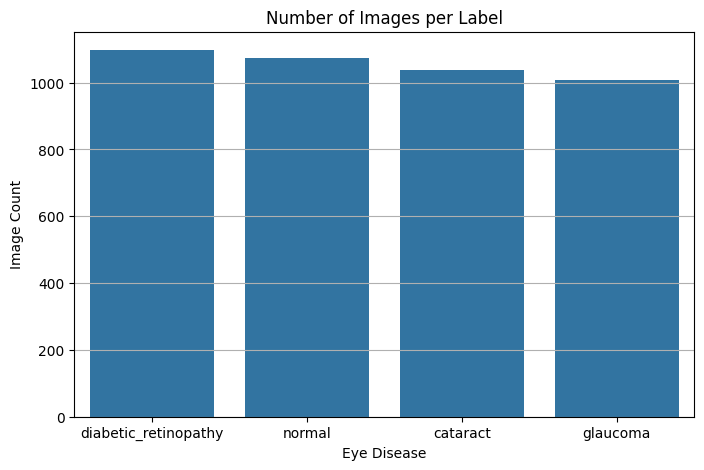

In [10]:
#no of images per label
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='label', order=df['label'].value_counts().index)
plt.title("Number of Images per Label")
plt.xlabel("Eye Disease")
plt.ylabel("Image Count")
plt.grid(axis='y')
plt.show()

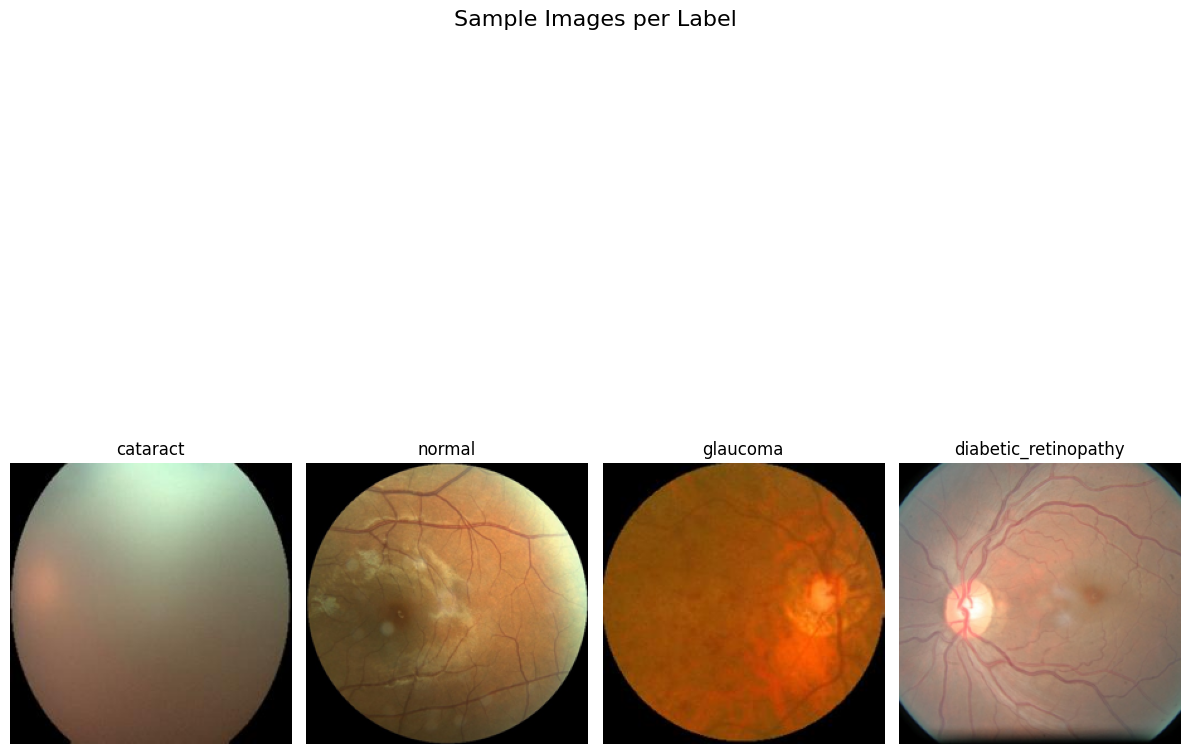

In [11]:
#1 sample per imag
unique_labels = df['label'].unique()

plt.figure(figsize=(12, 3 * len(unique_labels)))
for i, label in enumerate(unique_labels):
    # Get first image of each label
    base64_img = df[df['label'] == label].iloc[0]['image']
    image = Image.open(io.BytesIO(base64.b64decode(base64_img)))

    plt.subplot(1, len(unique_labels), i + 1)
    plt.imshow(image)
    plt.title(label)
    plt.axis("off")
plt.suptitle("Sample Images per Label", fontsize=16)
plt.tight_layout()
plt.show()

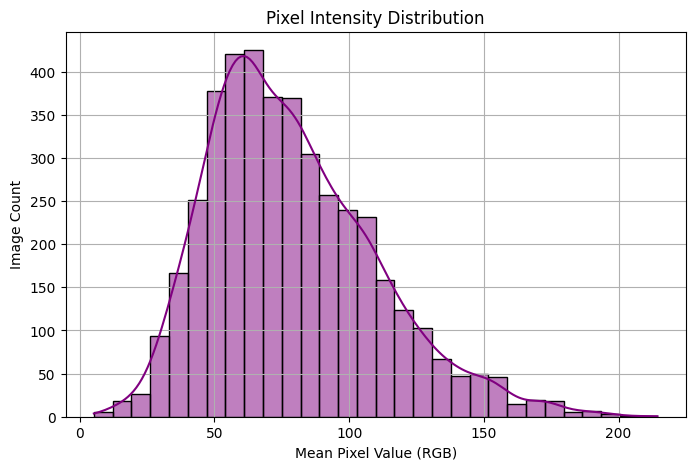

In [12]:
# pixel density
def pixelDist(df):
  pixel_means = []
  image_sizes = []

  for base64_img in df['image']:
      try:
          img = Image.open(io.BytesIO(base64.b64decode(base64_img))).convert  ("L")  # Grayscale
          np_img = np.array(img)
          pixel_means.append(np_img.mean())
          image_sizes.append(np_img.shape)
      except Exception as e:
          print("Error decoding for pixel density:", e)


  plt.figure(figsize=(8, 5))
  sns.histplot(pixel_means, bins=30, kde=True, color='purple')
  plt.title("Pixel Intensity Distribution")
  plt.xlabel("Mean Pixel Value (RGB)")
  plt.ylabel("Image Count")
  plt.grid(True)
  plt.show()

pixelDist(df)

In [13]:
#applying CLAHE

def apply_clahe(base64_str):
    try:
        # Decode base64 to bytes
        img_data = base64.b64decode(base64_str)
        img = Image.open(io.BytesIO(img_data)).convert("RGB")  # Ensure RGB mode

        # Convert PIL image to OpenCV format (numpy array)
        np_img = np.array(img)

        # Split the RGB channels
        r, g, b = cv2.split(np_img)

        # CLAHE object
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

        # Apply CLAHE to each channel
        r_clahe = clahe.apply(r)
        g_clahe = clahe.apply(g)
        b_clahe = clahe.apply(b)

        # Merge channels back
        clahe_rgb = cv2.merge((r_clahe, g_clahe, b_clahe))

        # Encode back to base64 (PNG format)
        success, buffer = cv2.imencode('.png', clahe_rgb)
        if not success:
            return None
        b64_encoded = base64.b64encode(buffer).decode('utf-8')
        return b64_encoded

    except Exception as e:
        print(f" error: {e}")
        return None

df['image'] = df['image'].apply(apply_clahe)

# Optionally: remove any failed images
#df.dropna(subset=['image'], inplace=True)

print("CLAHE applied to all images. All remain in RGB format.")

print(df.shape)

CLAHE applied to all images. All remain in RGB format.
(4217, 2)


In [14]:
#checking how many RGB are there
mode_counts = df['image'].apply(get_mode).value_counts()

print("Image Mode Counts:\n", mode_counts)

Image Mode Counts:
 image
RGB    4217
Name: count, dtype: int64


In [15]:
#saving current df
resized_csv_path = '/content/drive/MyDrive/Colab Notebooks/personal/Eye disease/dataset/data_encoded.csv'
df.to_csv(resized_csv_path, index=False)

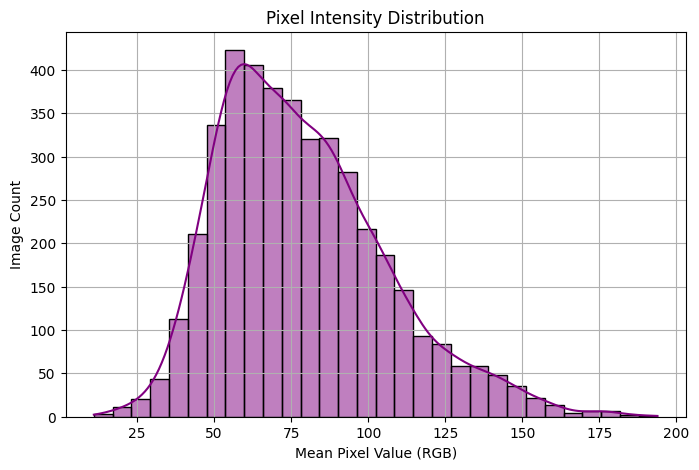

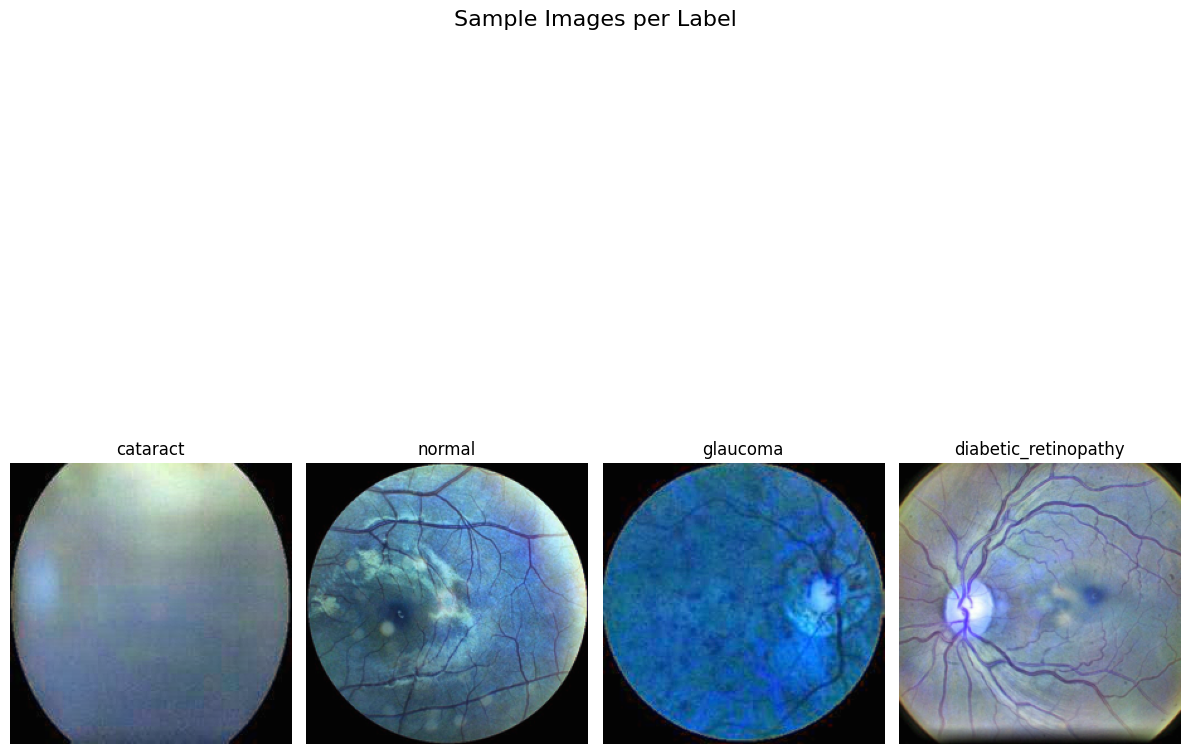

In [16]:
pixelDist(df)

#1 sample per imag
unique_labels = df['label'].unique()

plt.figure(figsize=(12, 3 * len(unique_labels)))
for i, label in enumerate(unique_labels):
    # Get first image of each label
    base64_img = df[df['label'] == label].iloc[0]['image']
    image = Image.open(io.BytesIO(base64.b64decode(base64_img)))

    plt.subplot(1, len(unique_labels), i + 1)
    plt.imshow(image)
    plt.title(label)
    plt.axis("off")
plt.suptitle("Sample Images per Label", fontsize=16)
plt.tight_layout()
plt.show()

In [17]:
'''
splitting the ds here
'''
#splitting the ds

label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['label'])

# Split into train+val and test
train_val_df, test_df = train_test_split(
    df,
    test_size=0.15,  # 15% test
    stratify=df['label_encoded'],
    random_state=42
)

# Then split train+val into train and validation
train_df, val_df = train_test_split(
    train_val_df,
    test_size=0.15 / 0.85,  # ~15% validation from train+val
    stratify=train_val_df['label_encoded'],
    random_state=42
)

# Check counts
print("Train size:", train_df.shape)
print("Validation size:", val_df.shape)
print("Test size:", test_df.shape)


# Function to decode base64 → RGB image → NumPy array (224x224)
def decode_and_resize(b64_string):
    img_data = base64.b64decode(b64_string)
    img = Image.open(io.BytesIO(img_data)).convert('RGB')  # ensure RGB
    img = img.resize((224, 224))
    return np.array(img)

# Function to process a dataframe into X, y
from tensorflow.keras.utils import to_categorical # Import to_categorical

def preprocess_df(df):
    X = np.array([decode_and_resize(b64) for b64 in df['image']])
    y = to_categorical(df['label_encoded'], num_classes=4)
    return X / 255.0, y  # normalize to [0, 1]

# Apply to each split
X_train, y_train = preprocess_df(train_df)
X_val, y_val = preprocess_df(val_df)
X_test, y_test = preprocess_df(test_df)  # if needed later

Train size: (2951, 3)
Validation size: (633, 3)
Test size: (633, 3)


In [21]:
'''
saving the split sets of train,testand val in drive
'''
save_path = "/content/drive/MyDrive/Colab Notebooks/personal/Eye disease/dataset"

np.save(f"{save_path}/X_train.npy", X_train)
np.save(f"{save_path}/y_train.npy", y_train)

np.save(f"{save_path}/X_val.npy", X_val)
np.save(f"{save_path}/y_val.npy", y_val)

np.save(f"{save_path}/X_test.npy", X_test)
np.save(f"{save_path}/y_test.npy", y_test)


print("SUCCESS")

SUCCESS
